`indices_oni_1.ncl`: NOAA's operational definitions of El Niño and La Niña conditions are based upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W]. The anomalies are derived from the 1971-2000 SST climatology.
The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. To be classified as a full-fledged El Niño and La Niña episode the ONI must exceed +0.5 [El Niño] or -0.5 [La Niña] for at least five consecutive months.


## UPDATE
NOAA has changed the operational definition of ONI. To reduce the influence of long-term trends, the definition now removes a 30-year climatology that is updated every 5 years. https://bmcnoldy.rsmas.miami.edu/tropics/oni/

Jump down to find an example that can reproduce this definition.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd  # used to convert YYYYMM to a datetime object


In [3]:
# Just for fun, let's define a version of printVarSummary:
# same as in indices_nino_1.ipynb
def printVarSummary(da):
    n = da.name
    if hasattr(da, 'units'):
        u = da.units
    else:
        u = None
    if hasattr(da, 'long_name'):
        lng = da.long_name
    else:
        lng = "NO LONG NAME"
    c = []
    for i in da.dims:
        if i in da.coords:
            c.append(f"\t dim: {i} with coordinate of shape {da.coords[i].shape}")
        else:
            c.append(f"\t dim: {i} with no coordinate variable")
    mn = da.min().values.item()
    mx = da.max().values.item()
    print(f"{n} ({u})\n  {lng}\n  minimum: {mn}\n  maximum: {mx}")
    for i in c:
        print(i)



In [4]:
#----------------------------------------------------------------------
# indices_oni_1.ncl
#
# Concepts illustrated:
#   - Computing the Oceanic Nino Index
#   - Drawing a time series plot
#----------------------------------------------------------------------
#
# These files are loaded by default in NCL V6.2.0 and newer
# load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_code.ncl"
# load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_csm.ncl" 
# load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/contributed.ncl" 
#---------------------------------------------------------------------------
# NOAA's operational definitions of El Niño and La Niña conditions are based
# upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running
# means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W]. The anomalies
# are derived from the 1971-2000 SST climatology.
#
# The Niño 3.4 anomalies may be thought of as representing the average equatorial
# SSTs across the Pacific from about the dateline to the South American coast.
# To be classified as a full-fledged El Niño and La Niña episode the ONI must excee
# d +0.5 [El Niño] or -0.5 [La Niña] for at least five consecutive months. 
#---------------------------------------------------------------------------
#                         User input
#---------------------------------------------------------------------------
latS   = -5.0
latN   =  5.0
lonL   = 190.0
lonR   = 240.0

nrun   = 3             # length of running average

ymStrt = 187001
ymLast = 201112        # last full year on file

clStrt = 197101        # climatology start    
clLast = 200012        #             last

yrStrt = ymStrt // 100  # NOTE: integer division
yrLast = ymLast // 100

pltType = "png"       # send graphics to PNG file
pltDir  = "./"        # dir to which plots are sent
#pltName = "ONI."+(ymStrt/100)+"-"+(ymLast/100)
pltName = "indices_oni"

pltTitle= "ONI: "+str(ymStrt//100)+"-"+str(ymLast//100) \
      + ": Base "+str(clStrt//100)+"-"+str(clLast//100)  # NOTE: this isn't my first choice for formatting, but just to show it works.

#-------------------- End User Input ---------------------------------------


In NCL (and many languages), you need to deal with getting the integer indices of arrays to select the correct sub-array. NCL is amazing that the `{}` notation can be used with coordinate array indexing. When using python in general, and numpy and xarray in particular, it is often a red flag if you find yourself really struggling to get indices of some value. In the next cell, the NCL example goes to some effort to deal with dates as integer values (`YYYYMM`). I am going to show how to do the same operations both with finding indices and using them, and also using coordinate slicing. The coordinate slicing works here because the time dimension is perfectly well-suited to selecting the range of time specified as `YYYY-MM-DD` strings. 

In [169]:
ds = xr.open_dataset("/Users/brianpm/Downloads/MODEL.SST.HAD187001-198110.OI198111-201203.nc")
date_format = "YYYYMM00"
sst_name = "SST"


# ds = xr.open_dataset("/Users/brianpm/Downloads/sst.mnmean-2.nc")  ## NOAA ERSSTv5
# sst_name = "sst"
# date_format = "cf"

# Check that dimensions are as expected:
if ds["lat"][-1] < ds["lat"][1]:
    ds = ds.reindex(lat=ds.lat[::-1])
    print("Reversed latitude")

# The HADSST data has a non-CF-compliant time dimension
if date_format == "YYYYMM00":
    YYYYMM = (ds["date"]) // 100  # ALL dates on file; note: integer division
    # just to show how to get these indices if you really need to:
    # NOTE: have to use `.values` because we need to convert to plain numpy array
    # NOTE: argwhere returns an array, so use `item()` to convert to a scalar
    tStrt = np.argwhere(YYYYMM.values == ymStrt).item()  # indices of selected times
    tLast = np.argwhere(YYYYMM.values == ymLast).item()
    print(
        f"The  start is {ymStrt} at index {tStrt}. The ending is {ymLast} at index {tLast}."
    )
    # NOTE: WARNING! python indexing inclusive on the beginning index and exclusive on the ending,
    # so you need to add 1 in this incantation
    x = (
        ds[sst_name]
        .isel(time=slice(tStrt, tLast + 1))
        .sel(lat=slice(latS, latN), lon=slice(lonL, lonR))
    )
    if "date" in ds:
        # example of dealing with the date data
        date = ds["date"][tStrt : tLast + 1]  # remember to add 1
        printVarSummary(date)
        yyyymm = date // 100
        ntim = len(date)
        print(f"Length of the date variable is {ntim}")
        # *********************************
        # time indices for base climatology
        # *********************************
        iClmStrt = np.argwhere(yyyymm.values == clStrt).item()
        iClmLast = np.argwhere(yyyymm.values == clLast).item()
        # *********************************
        # Climatology and anomalies from base climatology
        # *********************************
        xClm = (
            x[iClmStrt : iClmLast + 1, :, :].groupby("time.month").mean(dim="time")
        )  # Direct indexing just like NCL; clmMonTLL(x(iClmStrt:iClmLast,:,:))
        printVarSummary(xClm)
elif date_format == "cf":
    x = ds[sst_name].sel(
        time=slice(
            pd.to_datetime(ymStrt, format="%Y%m", errors="coerce"),
            pd.to_datetime(ymLast, format="%Y%m", errors="coerce"),
        ),
        lat=slice(latS, latN),
        lon=slice(lonL, lonR),
    )
    # Climatology (convert YYYYMM to datetime to slice, use groupby and mean)
    xClm = (
        x.sel(
            time=slice(
                pd.to_datetime(clStrt, format="%Y%m", errors="coerce"),
                pd.to_datetime(clLast, format="%Y%m", errors="coerce"),
            )
        )
        .groupby("time.month")
        .mean(dim="time")
    )
    printVarSummary(xClm)

printVarSummary(x)  # use our custom function (defined above)
printVarSummary(xClm)
# Example to show another method we could have used instead of converting to datetime
# xalt = ds[sst_name].sel(time=slice(f"{yrStrt}-01-01",f"{yrLast}-12-31"), lat=slice(latS,latN), lon=slice(lonL,lonR))
# printVarSummary(xalt)

# print(date(iClmStrt:iClmLast))

The  start is 187001 at index 0. The ending is 201112 at index 1703.
date (yyyymmdd)
  NO LONG NAME
  minimum: 18700116
  maximum: 20111216
	 dim: time with coordinate of shape (1704,)
Length of the date variable is 1704
SST (degC)
  Sea Surface Temperature
  minimum: 23.790515899658203
  maximum: 29.223142623901367
	 dim: month with coordinate of shape (12,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (degC)
  Sea Surface Temperature
  minimum: 20.400646209716797
  maximum: 30.750333786010742
	 dim: time with coordinate of shape (1704,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (degC)
  Sea Surface Temperature
  minimum: 23.790515899658203
  maximum: 29.223142623901367
	 dim: month with coordinate of shape (12,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)


In [19]:




xAnom = x.groupby('time.month') - xClm  # calcMonAnomTLL (x,  xClm ) 
xAnom.attrs['long_name'] = "SST Anomalies"
printVarSummary(xAnom)

#*********************************
# Unweighted areal average anomalies (time series)
# Small latitudinal extent so no need to weight    
#*********************************

xAnom_avg = xAnom.mean(dim=('lon','lat'))
xAnom_avg.attrs['long_name'] = "areal avg anomalies"
printVarSummary(xAnom_avg)

#*********************************
# Perform an unweighted 'nrun' month running average
#*********************************

xAnom_avg = xAnom_avg.rolling(time=nrun).mean()
printVarSummary(xAnom_avg)

sst (None)
  SST Anomalies
  minimum: -3.6552734375
  maximum: 4.426599502563477
	 dim: time with coordinate of shape (1704,)
	 dim: lat with coordinate of shape (5,)
	 dim: lon with coordinate of shape (26,)
sst (None)
  areal avg anomalies
  minimum: -2.6248226165771484
  maximum: 2.632565498352051
	 dim: time with coordinate of shape (1704,)
sst (None)
  areal avg anomalies
  minimum: -2.5436298847198486
  maximum: 2.5610978603363037
	 dim: time with coordinate of shape (1704,)


Text(0.5, 1.0, 'ONI: 1870-2011: Base 1971-2000')

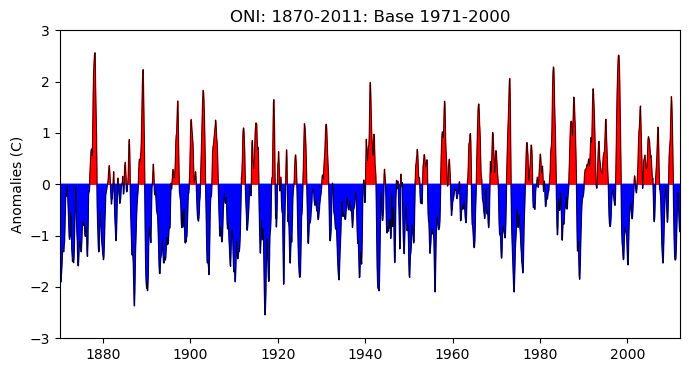

In [21]:
#*********************************
# plot graph
#*********************************
yrfrac = xAnom_avg['time.year'] + (xAnom_avg['time.month']/12)  # yyyymm_to_yyyyfrac(yyyymm, 0.0)

fig, ax = plt.subplots(figsize=(8,4))

trYMinF          = -3.0           # min value on y-axis
trYMaxF          =  3.0           # max value on y-axis
tiMainString     = pltTitle                            
tiYAxisString    = "Anomalies (C)"    # y-axis label
ax.plot(yrfrac, xAnom_avg, 'k', linewidth=0.5)
ax.fill_between(yrfrac, xAnom_avg, where=xAnom_avg>=0, interpolate=True, color='red')
ax.fill_between(yrfrac, xAnom_avg, where=xAnom_avg<0, interpolate=True, color='blue')
ax.set_ylabel(tiYAxisString)
ax.set_ylim([trYMinF, trYMaxF])
ax.set_xlim([yrfrac.min(), yrfrac.max()])
ax.set_title(pltTitle)


In [22]:
from matplotlib.font_manager import FontProperties
# we'll use this to control the fonts in the Table.

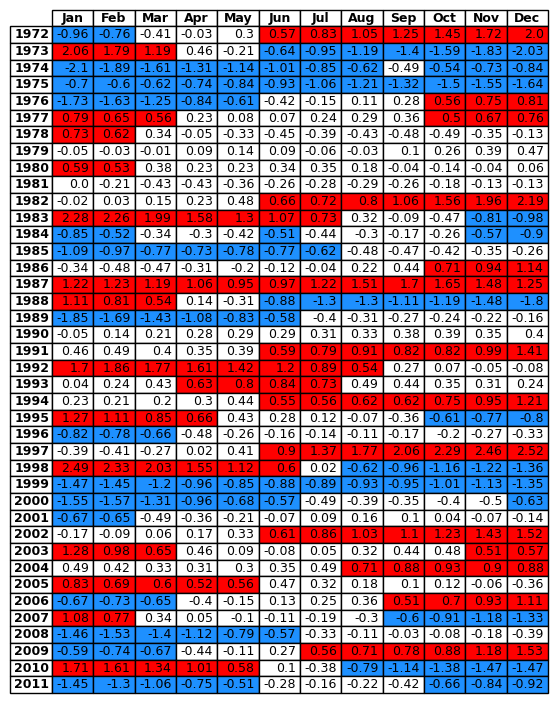

In [23]:
#*********************************
# plot table
#*********************************

#yrStrtTab = 1972
#yrLastTab = 2011
#nmos   = 12
#nyrs   = yrLastTab-yrStrtTab+1 # number of rows (nrows) 
#ncols  = nmos+1                # year and 12 monthly values
#nrc    = (/nyrs,ncols/)        # (/nrows,ncols/)
#tStrtTab = ind(yyyymm.eq.(yrStrtTab*100 + 1))
#tLastTab = ind(yyyymm.eq.(yrLastTab*100 +12))

data   = xAnom_avg.sel(time=slice('1972-01-01','2011-12-31'))
# reshape into years x months
data_reshape = np.reshape(data.values, (len(data)//12, 12))
# print(data_reshape)
# Colors
tabcol = []
for i, d in enumerate(data):
    if d <= -0.5:
        tabcol.append("dodgerblue")
    elif d >= 0.5:
        tabcol.append("r")
    else:
        tabcol.append("w")
tabcol = np.reshape(np.array(tabcol), (len(data)//12, 12))

months = ['Jan', 'Feb', 'Mar', "Apr", "May", 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

figTable, axTable = plt.subplots()
# Hide axes
axTable.axis('off')
table = axTable.table(cellText=np.around(data_reshape, decimals=2), cellColours=tabcol, rowLabels=np.arange(1972,2011+1),
              loc='center', colLabels=months, fontsize=14)
# make bold labels
for (row, col), cell in table.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# save PDF
# figTable.savefig("/Users/brianpm/Desktop/mpl_table.pdf", bbox_inches="tight", pad_inches=1)

## Updated ONI

Following Brian McNoldy's recipe:
Using the NOAA Climate Prediction Center methodology:
- Calculate a monthly average sea surface temperature in the Nino 3.4 region (5°S-5°N, 170°W-120°W).
- Calculate a monthly 30-year climatological value, updated every 5 years (1856-1885, ..., 1986-2015, 1991-2020).
- Calculate a monthly anomaly with years centered in the climatology (1871-1875 uses 1856-1885 climo, ..., 2001-2005 uses 1986-2015 climo, 2006-2010 uses 1991-2020 climo, 2011-2025 also uses 1991-2020 climo because 1996-2025 climo does not exist yet).
- Note that values prior to 1950 have greater uncertainty -- use with caution.
- All values are included in a data file at the bottom of the page.
- ONI ≥ 0.5°C indicate El Niño, values ≤ -0.5°C indicate La Niña, and values in between indicate a Neutral phase.


- https://www.climate.gov/news-features/understanding-climate/watching-el-ni%C3%B1o-and-la-ni%C3%B1a-noaa-adapts-global-warming

In [198]:
# Calculate a monthly average SST in the Nino 3.4 region
# --> This is just x, as we calculate above.

# Calculate a monthly 30-year climatological value, updated every 5 years (1856-1885, ..., 1986-2015, 1991-2020).

def proc(xg, wsize):
    dgrproll = xg.rolling(time=wsize)
    stack = dgrproll.construct('window_dim')  # result ('time', 'lat', 'lon', 'window_dim')
    stack = stack.isel(time=slice(wsize-1,None)) # take first window that *starts* with the beginning of the time period
    stack_mean = stack.mean(dim='window_dim') # averages over 30-year segments, time will be at END of segment
    # NOTE: if an ENDING YEAR WAS SPECIFIED, the final 30-year segment ends at that year
    # Stride through this stack of 30-year averages to only take the ones ending on years that are multiples of 5
    result = stack_mean.isel(time=np.argwhere( (stack_mean.time.dt.year % 5).values == 0 ).flatten())
    return result

# This is a multi-step calculation; start with a 30-year rolling mean
print(f"{x.shape = }, {x.time[0].dt.strftime('%Y-%m').item()} to {x.time[-1].dt.strftime('%Y-%m').item()}")
tt = x.groupby('time.month').map(proc, args=(30,)) # I think these are the 30-year climos, months are basically concatenated
print(f"{tt.shape = }")

x.shape = (1704, 10, 50), 1870-01 to 2011-12
tt.shape = (276, 10, 50)


In [201]:
# determine the index of the baseline climo to use for each time in x
bin_uppers = [y.item()-13 for y in tt.loc[tt.time.dt.month == 1].time.dt.year]
# assign every year of the original time series to one of these bins
baseline_index = np.digitize(x.time.dt.year.values, bin_uppers, right=True)
baseline_index_xr = xr.DataArray(baseline_index, dims=['time'], coords={'time':x.time})
baseline_index_xr.name = 'baseline_index'

# Subtract baseline climo from the data to get the anomaly
# keep using the last climo for all the years at the end.
ans = x.copy()
for t in range(len(x.time)):
    ndx = baseline_index_xr.isel(time=t).item()
    month = x.isel(time=t).time.dt.month.item()
    climo = tt.groupby('time.month')[month]
    if ndx > (len(climo['time'])-1):
        ndx = len(climo['time'])-1  # use last bin (equiv to ffill)
    ans[dict(time=t)] = x.isel(time=t) - climo.isel(time=ndx)

In [163]:
# first repeat the NCL-like calculation but with the new definition
xAnom_avg = ans.mean(dim=('lon','lat'))
xAnom_avg.attrs['long_name'] = "areal avg anomalies"
printVarSummary(xAnom_avg)

#*********************************
# Perform an unweighted 'nrun' month running average
#*********************************

xAnom_avg = xAnom_avg.rolling(time=nrun).mean()
printVarSummary(xAnom_avg)

sst (None)
  areal avg anomalies
  minimum: -2.3972318172454834
  maximum: 3.0319759845733643
	 dim: time with coordinate of shape (1704,)
sst (None)
  areal avg anomalies
  minimum: -2.3008031845092773
  maximum: 2.902388572692871
	 dim: time with coordinate of shape (1704,)


Text(0.5, 1.0, 'ONI: 1870-2011: Base 1971-2000')

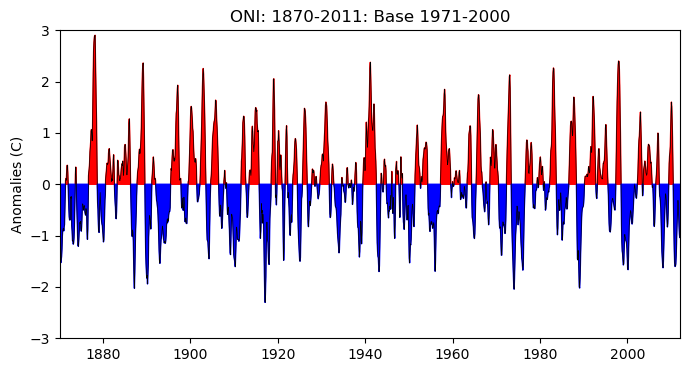

In [164]:
#*********************************
# plot graph
#*********************************
yrfrac = xAnom_avg['time.year'] + (xAnom_avg['time.month']/12)  # yyyymm_to_yyyyfrac(yyyymm, 0.0)

fig, ax = plt.subplots(figsize=(8,4))

trYMinF          = -3.0           # min value on y-axis
trYMaxF          =  3.0           # max value on y-axis
tiMainString     = pltTitle                            
tiYAxisString    = "Anomalies (C)"    # y-axis label
ax.plot(yrfrac, xAnom_avg, 'k', linewidth=0.5)
ax.fill_between(yrfrac, xAnom_avg, where=xAnom_avg>=0, interpolate=True, color='red')
ax.fill_between(yrfrac, xAnom_avg, where=xAnom_avg<0, interpolate=True, color='blue')
ax.set_ylabel(tiYAxisString)
ax.set_ylim([trYMinF, trYMaxF])
ax.set_xlim([yrfrac.min(), yrfrac.max()])
ax.set_title(pltTitle)

In [166]:
# Improve by taking the correct weighted averages
xAnom_avg = ans.weighted(np.cos(np.radians(ans.lat))).mean(dim=('lon','lat'))
xAnom_avg.attrs['long_name'] = "areal avg anomalies"
printVarSummary(xAnom_avg)

#*********************************
# Perform 'nrun' month running average, weighted by days in month
#*********************************
window_size = 3
month_weights = xr.DataArray(xAnom_avg.time.dt.daysinmonth, coords=xAnom_avg.coords) 

xa_rolling = xAnom_avg.rolling(time=window_size).construct("window")
month_weights_rolling = month_weights.rolling(time=window_size).construct("window")

xAnom_avg_weighted = xa_rolling.weighted(month_weights_rolling.fillna(0)).mean('window')

printVarSummary(xAnom_avg_weighted)

sst (None)
  areal avg anomalies
  minimum: -2.3975305557250977
  maximum: 3.0322113037109375
	 dim: time with coordinate of shape (1704,)
sst (None)
  NO LONG NAME
  minimum: -2.301020057305046
  maximum: 2.898340280850728
	 dim: time with coordinate of shape (1704,)


Text(0.5, 1.0, 'ONI: 1870-2011: 30-year shifting baseline')

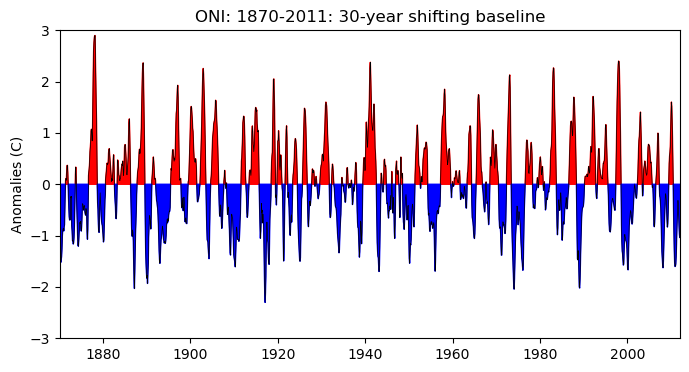

In [168]:
yrfrac = xAnom_avg_weighted['time.year'] + (xAnom_avg_weighted['time.month']/12)  # yyyymm_to_yyyyfrac(yyyymm, 0.0)

fig, ax = plt.subplots(figsize=(8,4))

trYMinF          = -3.0           # min value on y-axis
trYMaxF          =  3.0           # max value on y-axis
tiMainString     = pltTitle                            
tiYAxisString    = "Anomalies (C)"    # y-axis label
ax.plot(yrfrac, xAnom_avg_weighted, 'k', linewidth=0.5)
ax.fill_between(yrfrac, xAnom_avg_weighted, where=xAnom_avg_weighted>=0, interpolate=True, color='red')
ax.fill_between(yrfrac, xAnom_avg_weighted, where=xAnom_avg_weighted<0, interpolate=True, color='blue')
ax.set_ylabel(tiYAxisString)
ax.set_ylim([trYMinF, trYMaxF])
ax.set_xlim([yrfrac.min(), yrfrac.max()])

pltTitle= f"ONI: {xAnom_avg_weighted.time.dt.year.min().item()}-{xAnom_avg_weighted.time.dt.year.max().item()}: 30-year shifting baseline"
ax.set_title(pltTitle)

In [220]:
#
# Finally, let's produce some portable code that is a little more abstracted
#

# Let's separate the calculation steps into functions, 
# driven by a set of parameters
#
# We only need SST in the Nino3.4 region as data
# assume the user can provide a dataset object with some variable that is equivalent to SST
# INPUT: ds, variable_name
#     assume: dimensions of time, lat, and lon
#     Since NCL example data didn't have CF compliant time, let's provide an option to use YYYYMM00 or CF-compliant
# INPUT: is_cf_compliant -> True/False (But really the user should normally have to do this)

def check_time_coord(ds):
    """Tries to diagnose if time is decoded as datetime objects."""
    is_dt = False
    if 'time' in ds.dims:
        if 'time' in ds.coords:
            is_dt = np.issubdtype(ds['time'].dtype, np.datetime64)
            print(f"{ds['time'].dtype = }")
    print(f"{is_dt = }")
    return is_dt
    

def convert_non_cf_time(ds):
    """Input is YYYYMM00 (but still monthly). Convert to datetime."""
    YYYYMM = (ds["date"]) // 100  # ALL dates on file; note: integer division
    time = [pd.to_datetime(d, format="%Y%m", errors="coerce") for d in YYYYMM]
    return ds.assign_coords({"time":time})


def check_increasing_latitude(ds):
    assert 'lat' in ds.coords, 'lat not a coordinate in ds'
    if ds["lat"][-1] < ds["lat"][1]:
        print("Reversed latitude")
        return ds.reindex(lat=ds.lat[::-1])
    else:
        return ds


def get_region(ds, region):
    """return the region defined by region"""
    return ds.sel(lat=slice(region[0],region[1]), lon=slice(region[2],region[3]))

def noaa_shifting_climo(data, climo_length=30, shift_freq=5):
    """
    Groups data by month, calculates the climo_length moving average for each month,
    reduce to only the averages that end with a year divisible by 5,
    and returns that as a data array that has these averages for each month concatenated.
    Here "concatenated" means that the time dimension is non-monotonic (year repeats 12 times).
    """
    def proc(xg, wsize):
        dgrproll = xg.rolling(time=wsize)
        stack = dgrproll.construct('window_dim')  # result ('time', 'lat', 'lon', 'window_dim')
        stack = stack.isel(time=slice(wsize-1,None)) # take first window that *starts* with the beginning of the time period
        stack_mean = stack.mean(dim='window_dim') # averages over 30-year segments, time will be at END of segment
        # NOTE: if an ENDING YEAR WAS SPECIFIED, the final 30-year segment ends at that year
        # Stride through this stack of `climo_length`-year averages to only take the ones ending on years divisible by `shift_freq`
        result = stack_mean.isel(time=np.argwhere( (stack_mean.time.dt.year % shift_freq).values == 0 ).flatten())
        return result
    return data.groupby('time.month').map(proc, args=(climo_length,)) # I think these are the 30-year climos, months are basically concatenated

def subtract_climo(data, climo, climo_length, shift_freq):
    # determine the index of the baseline climo to use for each time in x
    # 13 here is because 30 / 2 = 15; 15 - 5//2 = 13 To only take the center 5 years
    offset = (climo_length//2) - (shift_freq//2)
    print(type(climo))

    print(f"{climo.loc[climo.time.dt.month == 1] = }")
    # print(f"{climo.loc[climo.time.dt.month == 1].time.dt.year = }")
    bin_uppers = [y.item()-offset for y in climo.loc[climo.time.dt.month == 1].time.dt.year]
    # assign every year of the original time series to one of these bins
    baseline_index = np.digitize(data.time.dt.year.values, bin_uppers, right=True)
    baseline_index_xr = xr.DataArray(baseline_index, dims=['time'], coords={'time':x.time})
    baseline_index_xr.name = 'baseline_index'
    # Subtract baseline climo from the data to get the anomaly
    # keep using the last climo for all the years at the end.
    ans = data.copy()
    for t in range(len(data.time)):
        ndx = baseline_index_xr.isel(time=t).item()
        month = data.isel(time=t).time.dt.month.item()
        monclimo = climo.groupby('time.month')[month]
        if ndx > (len(monclimo['time'])-1):
            ndx = len(monclimo['time'])-1  # use last bin (equiv to ffill)
        ans[dict(time=t)] = data.isel(time=t) - monclimo.isel(time=ndx)
    return ans


def filter_index(anom, window_size=3):
    """Construct an `index` by taking area average and applying running average."""
    xAnom_avg = anom.weighted(np.cos(np.radians(anom.lat))).mean(dim=('lon','lat'))
    xAnom_avg.attrs['long_name'] = "areal avg anomalies"
    #*********************************
    # Perform 'nrun' month running average, weighted by days in month
    #*********************************
    month_weights = xr.DataArray(xAnom_avg.time.dt.daysinmonth, coords=xAnom_avg.coords) 
    xa_rolling = xAnom_avg.rolling(time=window_size).construct("window")
    month_weights_rolling = month_weights.rolling(time=window_size).construct("window")
    return xa_rolling.weighted(month_weights_rolling.fillna(0)).mean('window')


def oni_calculation(ds, latS, latN, lonL, lonR, climo_length=None, shift_freq=None, window_size=None):
    if not check_time_coord(ds):
        ds = convert_non_cf_time(ds)
    ds = check_increasing_latitude(ds)
    region = (latS, latN, lonL, lonR)
    dreg = get_region(ds, region)
    tt = noaa_shifting_climo(dreg, climo_length=30, shift_freq=5)
    anom = subtract_climo(dreg, tt, climo_length, shift_freq)
    return filter_index(anom, window_size=window_size)



In [221]:
oni = oni_calculation(ds['SST'], latS, latN, lonL, lonR, climo_length=30, shift_freq=5, window_size=3)

ds['time'].dtype = dtype('<M8[ns]')
is_dt = True
<class 'xarray.core.dataarray.DataArray'>
climo.loc[climo.time.dt.month == 1] = <xarray.DataArray 'SST' (time: 23, lat: 10, lon: 50)>
array([[[28.456665, 28.380669, 28.335665, ..., 25.272667, 25.199001,
         25.133667],
        [28.208662, 28.141663, 28.130667, ..., 25.128334, 25.062998,
         24.969332],
        [27.860332, 27.809998, 27.819668, ..., 24.82134 , 24.779333,
         24.688665],
        ...,
        [27.420664, 27.382   , 27.339666, ..., 25.600668, 25.524332,
         25.444334],
        [27.597998, 27.549328, 27.51133 , ..., 26.08    , 26.016   ,
         25.927332],
        [27.73533 , 27.711662, 27.699665, ..., 26.383669, 26.318996,
         26.273668]],

       [[28.581665, 28.514668, 28.486   , ..., 25.481333, 25.407331,
         25.343998],
        [28.334663, 28.275331, 28.281   , ..., 25.336996, 25.271667,
         25.179668],
        [27.993   , 27.95133 , 27.979002, ..., 25.038668, 24.99767 ,
         24.9

ValueError: conflicting sizes for dimension 'time': length 1707 on the data but length 1704 on coordinate 'time'

In [214]:
ds

<xarray.Dataset>
Dimensions:    (time: 1707, lon: 360, lat: 180)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T12:00:00 ... 2012-03-16T12:00:00
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    date       (time) int32 18700116 18700215 18700316 ... 20120215 20120316
    datesec    (time) int32 ...
    date_frac  (time) float64 ...
    SST        (time, lat, lon) float32 ...
Attributes:
    creation_date:             Mon Apr  7 14:45:47 MDT 2008
    creator:                   Dennis Shea, CGD
    story:                     \nClara Deser and Jim Hurrell wanted a SST and...
    title:                     SST: Merged: HADLEY 187001-198110 with  NCEP O...
    history:                   Tue Apr 10 11:08:42 2012: ncrcat MODEL.SST.HAD...
    nco_openmp_thread_number:  1

In [217]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True